# MixedLayer_ModeSolve_paper

Solve modal structure including a mixed layer, for comparison with d'Asaro 1978 <br/>
* take stratif in "lowpass" file
* use modified stratif for theory only
* figure dedicated to paper

Adapted from MixedLayer_ModeSolve

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth']= 2.5
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

import numpy as np
#import scipy.integrate as itg
import scipy.interpolate as itp
import scipy.optimize as opt
from netCDF4 import Dataset
import sys

#from cheb import cheb
if '/home/lahaye/Coding/Python_ROMS_Modules/lahaye/' not in sys.path:
    sys.path.append('/home/lahaye/Coding/Python_ROMS_Modules/lahaye/')
from comp_zlevs import zlev_w, zlev_rho
from ML_ModeSolve import *
if "/home/lahaye/Coding/python_science" not in sys.path:
    sys.path.append("/home/lahaye/Coding/python_science")
from SL_chebsolve import SL_chebsolve
if "/home/lahaye/Coding/Py3_ROMS_Modules" not in sys.path:
    sys.path.append("/home/lahaye/Coding/Py3_ROMS_Modules")
from R_tools import vinterp

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# WARNING these will overwritten what is in ML_modesolve.py
# should be use to update this module, but need to ensure 
# compatibility e.g. with plot_kw-spectra-ratio_WKBamp.ipynb

def symsqrt(x):
    return np.sign(x)*np.sqrt(abs(x))

def get_strat_from_path(path_strat, zin, zml, dml=20, zpyc=-200, 
                        Hbt=3000, Nsqml=0, coef_realstrat=1., coord=None):
    #""" work only for "mean file" """
    nc = Dataset(path_strat, "r")
    ncvar = nc.variables
    if coord is None:
        zinterp = ncvar['z'][:]
        bvfm = ncvar['bvf'][:]
    else:
        jy, ix = coord
        topo = ncvar['h'][jy,ix]
        hc, Cs_r, Cs_w = nc.hc, nc.Cs_r, nc.Cs_w
        bvfm = ncvar['bvf_avg'][:,jy,ix]
        bvfm = np.r_[ bvfm[0], bvfm, bvfm[-1] ]
        zinterp = zlev_w(topo, np.zeros(1), hc, Cs_w).squeeze()
    nc.close()
    return get_strat(bvfm, zinterp, zin, zml, dml=20, zpyc=-200, Hbt=3000, Nsqml=0, coef_realstrat=1.)

def get_strat(bvfm, zinterp, zin, zml, dml=20, zpyc=-200, Hbt=3000, Nsqml=0, coef_realstrat=1., sm=0.):

    izml = abs(zinterp + 2*dml).argmin() # ad hoc, twice base of ML
    izpyc = izml #abs(zinterp - zpyc).argmin() # +:- permanent pycnocline
    izbt = abs(zinterp + Hbt).argmin()   # domain considered
    Nsqml *= np.ones(len(zml))
    print(izpyc, izbt)
    print(zinterp[izpyc], zinterp[izbt], zinterp[izml])
    bvf_int = np.trapz(bvfm[izbt:izpyc], zinterp[izbt:izpyc])/(zinterp[izpyc-1]-zinterp[izbt])

    Nsqin = itp.UnivariateSpline(zinterp, bvfm, s=sm)(zin)
    Nsqin = (1-coef_realstrat)*bvf_int + coef_realstrat*Nsqin
    gr_eff = np.trapz(bvfm[izml:], zinterp[izml:])
    return Nsqin, Nsqml, bvf_int, gr_eff

def get_strat_lf(path_strat, zin, zml, dml=20, zpyc=-200, Hbt=3000, Nsqml=0):
    nc = Dataset(path_strat, "r")
    hc, Cs_r, Cs_w = nc.hc, nc.Cs_r, nc.Cs_w
    bvfm = nc.variables ['bvf_avg'][:]
    bvfm = np.r_[bvfm[:1,...], 0.5*(bvfm[1:,...]+bvfm[:-1,...]), bvfm[-1:,...]]
    topo = nc.variables['h'][:]
    nc.close()
    zr = zlev_rho(topo, np.zeros(topo.shape), hc, Cs_r)
    zw = zlev_w(topo, np.zeros(topo.shape), hc, Cs_w).squeeze()
    zz = np.r_[zin, zml]
    zinterp = np.unique(zz)
    bvfm = np.nanmean(vinterp(np.moveaxis(bvfm, 0, 2), zinterp, zr, zw, interp_sfc=0) \
                        , axis=(0,1))
    Nsqin, Nsqml, bvf_int, gr_eff = get_strat(bvfm, zinterp, zin, zml, dml, zpyc, Hbt \
                                  , Nsqml, 1., sm=0) 
    return Nsqin, Nsqml, bvf_int, gr_eff, bvfm, zinterp

In [14]:
# Set up parameters

zpyc = -200   # upper level to take min for interior bvf
Nml = 0     # bvf in the mixed layer (constant)
Hbt = 3400
season = "winter"
zref = -500
dmls = {"summer":25, "winter":150} #{"summer":20, "winter":100}
gred = 0

dosavefig = True
dirpic = "pictures/paper_figs/"
cols = {"das":"tab:red", "wkb":"tab:olive", "num":"tab:blue", 
        "raw":"black"}
labs = {"das":r"piecwise-const. $N$", "wkb":"WKBJ", "num":"EVP with ML", 
        "raw":r"EVP, raw $N$"}
axlabs = {"summer":("a","b","c"), "winter":("d","e","f")}

Nz = 120
nmod = 40 # number of modes to plot

path_strat = RUCHBA+"{0}_tseries_lf/{0}_subsamp_strat_{1}.nc".format("luckyt",season[:3])

nc = Dataset(path_strat, "r")
hc, Cs_r, Cs_w = nc.hc, nc.Cs_r, nc.Cs_w
nc.close()
zb = zlev_w(Hbt, 0, hc, Cs_w)

In [15]:
# numerical solution with unmodified stratif
dml = 0
zin, Din, zml, Dml, zz, Dz = ML_solver_grid(Nz, Hbt, dml)

Nsqin, Nsqml, bvf_int, gr_eff, bvfm, zinterp = get_strat_lf(path_strat, zin, zml, dml \
                                                            , zpyc, Hbt, Nml**2)

(wa, da), lam, _ = SL_chebsolve(Nsqin, zin, Nz=Nz)
da /= -lam[None,:].real
# normalize
wa /= da[:1,:]
da /= da[:1,:]
# compute WKBJ amplitude
Npyc = np.where(zin <= zpyc)[0][-1] 
amp = np.sqrt(wa[:Npyc,:]**2*np.sqrt(Nsqin)[:Npyc,None] \
              + (da[:Npyc,:]**2/np.sqrt(Nsqin)[:Npyc,None])).mean(axis=0)
izref = abs(zref-zin).argmin()
za = zz
rat_raw = ((da[-1,:nmod])**2) / np.sqrt(Nsqin[izref]/Nsqin[0])
# stratif
Nraw = symsqrt(itp.pchip(zinterp, bvfm)(zb))

no Mixed Layer
119 0
0.0 -3400.0 0.0


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


In [16]:
# numerical solution with modified stratif
dml = dmls[season]
zin, Din, zml, Dml, zz, Dz = ML_solver_grid(Nz, Hbt, dml)

Nsqin, Nsqml, bvf_int, gr_eff, bvfm, zinterp = get_strat_lf(path_strat, zin, zml, dml, zpyc, Hbt, Nml**2)

# solve eigenproblem
lom, wo, do = ML_solver(zin, Din, Nsqin, zml, Dml, Nsqml, gred)
  
# normalize
wo /= do[:1,:]
do /= do[:1,:]

izref = abs(zref-zin).argmin()
rat_num = (do[-1,:nmod])**2 / np.sqrt(Nsqin[izref]/Nsqin[0])

if season == "winter": gr_eff = 0

print("reduced gravity:", gr_eff)

92 0
-305.062581217 -3400.0 -305.062581217
reduced gravity: 0


In [17]:
# find WKBJ wavenumbers solving transcendental equation

ff = lambda k:tr_ek(k, sym_sqrt(Nsqml.mean()), zin, Nsqin, gred).squeeze()

kzos = lom[:nmod].real
for ii,ll in enumerate(kzos):
    kzos[ii] = opt.fsolve(ff, ll)[0]

wkb_ratref = ((dwdz_ml(zml, sym_sqrt(Nsqml.mean()), kzos) \
        * w_in(zin, Nsqin, kzos)[-1,:])**2).mean(axis=0) / np.sqrt(Nsqin[izref]/Nsqin[0])


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


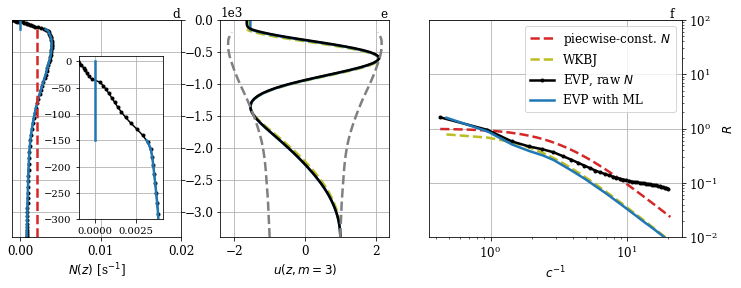

In [18]:
# plot results (stratif, modal struct and ratio)imod = 2 #indice of mode to show structure
imod = 2

fig = plt.figure(figsize=(12,4))

gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 3], wspace=.2)

### Stratification
ax1 = plt.subplot(gs[0])
inax = inset_axes(ax1, width="50%", height="75%", loc=4, borderpad=1.5)
for ax in [inax,ax1]:
    ax.plot(Nraw, zb, '.-', color=cols["raw"], lw=1.5)
    ax.plot(sym_sqrt(Nsqin), zin, '-', color=cols["num"])
    ax.plot(sym_sqrt(Nsqml), zml, '-', color=cols["num"])
ax1.plot(np.ones(len(zin))*np.sqrt(bvf_int), zin, "--", color=cols["das"])
ax1.set_xlim([-1e-3, 2e-2])
ax1.set_ylim([-Hbt, 0])
inax.grid(True)
inax.set_ylim([-300,10])
inax.set_xlim([-1e-3, inax.get_xlim()[-1]])

inax.tick_params(labelsize=10)

# Mode structure

ax2 = plt.subplot(gs[1])

if season == "summer":
    inax = inset_axes(ax2, width="30%", height="60%", loc=3, borderpad=1.5)
    inax.grid(True)
    inax.set_ylim([-300,10])
    inax.yaxis.tick_right()
    #inax.set_xlim([-1e-3, inax.get_xlim()[-1]])
    inax.tick_params(labelsize=10)
    axs = [inax, ax2]
else:
    axs = [ax2]
for ax in axs:
    ax.plot(dwdz_in(zin, Nsqin, kzos[imod]), zin, '--', color=cols["wkb"])
    ax.plot(dwdz_ml(zml, sym_sqrt(Nsqml.mean()), kzos[imod])\
         *w_in(zin, Nsqin, kzos[imod])[-1], zml, '--', color=cols["wkb"])
    ax.plot(do[:,imod], zz, '-', color=cols["num"]) # do = -w'/k
    ax.plot(da[:,imod], za, '-', color=cols["raw"]) # do = -w'/k

    ax.plot(amp[imod]*Nsqin[:Npyc]**(1./4), zin[:Npyc], "--", color="grey")
    ax.plot(-amp[imod]*Nsqin[:Npyc]**(1./4), zin[:Npyc], "--", color="grey")
ax1.set_yticklabels([])
ax2.set_ylim([-Hbt, 0])
ax2.ticklabel_format(style='sci',scilimits=(-2,2))
ax1.yaxis.tick_right()

# amplitude ratio
ax3 = plt.subplot(gs[2])
kks = np.linspace(.9*lom[0],lom[nmod],150)
ax3.loglog(kks, fasa(kks, dml, bvf_int, gr_eff), "--" \
           , color=cols["das"], label=labs["das"])
ax3.loglog(kzos[:nmod], wkb_ratref[:nmod], '--' \
           , color=cols["wkb"], label=labs["wkb"])
ax3.loglog(lam[:nmod], rat_raw \
          , ".-", color=cols["raw"], label=labs["raw"])
ax3.loglog(lom[:nmod], rat_num \
           , '-', color=cols["num"], label=labs["num"])
#ax4.loglog(lom[:nmod], ((do[-Nml:,:nmod])**2).mean(axis=0) / np.sqrt(Nsqin[izref]/Nsqin[0]), '--k')
#ax4.loglog(lom[:nmod], ((do[-Nml:,:nmod])**2).mean(axis=0) / (do[:Nin,:nmod]**2).mean(axis=0), 'o-k', label="Num.")
ax3.yaxis.tick_right()
ax3

if season == "winter": # bottom panel
    ax1.set_xlabel(r'$N(z)$ [s$^{-1}$]')
    ax2.set_xlabel(r'$u(z,'+"m={}".format(imod+1)+')$')
    ax3.set_xlabel(r'$c^{-1}$')
    ax3.legend(loc="best")
ax3.yaxis.set_label_position("right")
ax3.set_ylabel(r"$R$")    
ax3.set_ylim([1e-2, 1e2])

for ia,ax in enumerate([ax1, ax2, ax3]):
    ax.grid(True)
    ax.text(.95, 1.01, axlabs[season][ia], transform=ax.transAxes)
    
fig.set_tight_layout(True)
#fig.suptitle(r"{0}, d_ML={1:.1f}m, H_bot={2:.1f}m".format(season, dml, Hbt))

if dosavefig:
    fig.savefig(dirpic+"{0}_ratio-vs-k_DAsaro-plus_deep{1}.pdf".format(season, int(Hbt)), magnification="auto", dpi=200, bbox_inches="tight")

In [13]:
dosavefig

True

## Old Stuff

1 0.961830027294 0.961830027294


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

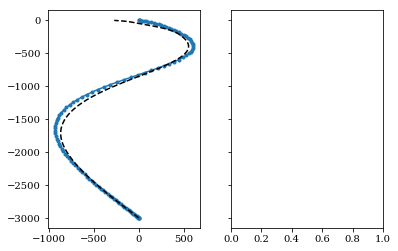

In [43]:

imod = 1

print(imod, lom[imod].real, kzos[imod])

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(wo[:,imod], zz, '.-')
#axs[0].plot(-np.sin(lom[imod]*mwkb)/(Nsqin[0]*Nsqin)**(1./4), zin, "--k")
axs[0].plot(-kzos[imod]*w_in(zin, Nsqin, kzos[imod]), zin, '--k')
axs[0].plot(-kzos[imod]*w_ml(zml, sym_sqrt(Nsqml.mean()), kzos[imod])*w_in(zin, Nsqin, kzos[imod])[-1], zml, "--k")
axs[0].set_xlabel('w')
axs[0].set_ylabel('z')
axs[0].legend(['Num.','WKBJ'])
axs[1].plot(do[:,imod], zz, '.') # do = -w'/k
#axs[1].plot(np.cos(lom[imod]*mwkb)*(Nsqin/Nsqin[0])**(1./4), zin, "--k")
axs[1].plot(dwdz_in(zin, Nsqin, kzos[imod]), zin, '--k')
axs[1].plot(dwdz_ml(zml, sym_sqrt(Nsqml.mean()), kzos[imod])*w_in(zin, Nsqin, kzos[imod])[-1], zml, '--k')

#axs[1].plot(-np.dot(Dz,wo[:,imod])/lom[imod], zz, '--')
axs[1].plot(amp[imod]*Nsqin**(1./4), zin, "--r")
axs[1].plot(-amp[imod]*Nsqin**(1./4), zin, "--r")
axs[1].set_xlabel(r'$\phi$')

for ax in axs:
    ax.grid(True)
    ax.ticklabel_format(style='sci',scilimits=(-2,2))
#ax.set_ylim([-500, 0])


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


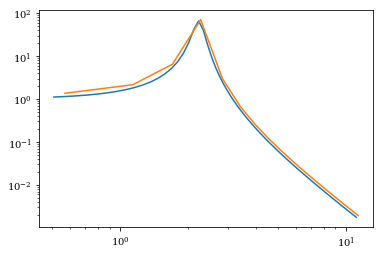

In [89]:
plt.figure()
ax = plt.gca()
ax.loglog(kks, fasa(kks, dml, bvf_int, gred))
kapprox = (np.arange(nmod)+1)*np.pi/np.sqrt(bvf_int)/Hbt
ax.loglog(kapprox, fasa(kapprox, dml, bvf_int, gred)*Nsqin[izref]/Nsqin[0])


## Trying stuff

In [15]:
kks = np.logspace(-1, 1, 100)
wkbrat = get_WKBampRat(path_strat, kzos, dml, Hbt, zref, zpyc, 0, gred)
plt.loglog(kzos, wkbrat, "+k")
plt.loglog(kzos[:], wkb_ratref[:], 'xr')

KeyError: 'z'

In [7]:
Hbt

3000

/data0/project/vortex/lahaye/DIAG/luckym2s_bvf_moy.nc 120 3000 20 0.02 -500 -200 [  1.00000000e-05   1.00000000e-05   1.00000000e-05   1.00000000e-05
   1.00000000e-05   1.00000000e-05   1.00000000e-05   1.00000000e-05
   1.00000000e-05   1.00000000e-05   1.00000000e-05   1.00000000e-05] 1.0


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


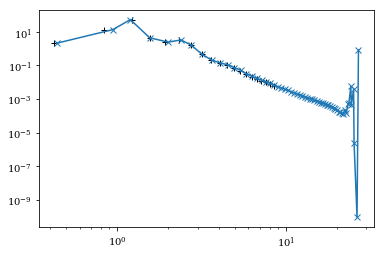

In [7]:
nmod = 20
print(path_strat, Nz, Hbt, dml, gred, zref, zpyc, Nsqml, coef_restrat)
lam, rats = get_ModAmpRat(path_strat, Hbt, dml, gred, zref, zpyc, Nsqml, coef_restrat)

plt.loglog(lom[:nmod], ((do[-Nml:,:nmod])**2).mean(axis=0) / np.sqrt(Nsqin[izref]/Nsqin[0]), '+k')
plt.loglog(lam, rats, 'x-')

## Old stuff
although correct 

In [218]:
# old version, piecewise constant stratification (N=0 in ML), non-hydro

om = 2*np.pi/(2*3600)
Ni = 3*2*np.pi/3600.
delrho = 1e-3 #0. #
dml = 20
Hbt = 2000

Nz = 80

Nml = max(int(Nz*dml/Hbt), int(Nz/10))
Nin = Nz - Nml

grav = 9.81
gred = grav*delrho
fcor = 1e-5
mu = 1./np.sqrt(1-fcor**2/om**2)
al = np.sqrt((Ni**2-om**2)/(om**2-fcor**2))

Nmod = int(Nz/3)

Dml, zml = cheb(Nml, [-dml, 0])
Din, zin = cheb(Nin, [-Hbt, -dml])
zz = np.r_[zin, zml]
Dz = np.zeros((Nz,Nz))
Dz[:Nin,:Nin] = Din
Dz[Nin:,Nin:] = Dml

alm2 = 1./al**2 # WARNING this will change for non constant stratification
mum2 = 1./mu**2

Lin = np.r_[ np.c_[ np.diag(np.ones(Nin)), -Din ] \
           , np.c_[ -alm2*Din,              np.zeros((Nin,Nin)) ] ]
Lml = np.r_[ np.c_[ np.diag(np.ones(Nml)), -Dml ] \
           , np.c_[ mum2*Dml,              np.zeros((Nml,Nml)) ] ]

LL = np.zeros((2*Nz,2*Nz))
LL[:2*Nin,:2*Nin] = Lin
LL[2*Nin:,2*Nin:] = Lml

AA = np.diag(np.r_[np.zeros(Nin), np.ones(Nin), np.zeros(Nml), np.ones(Nml)])

# B.C.
# w = 0 at z=-Hb, 0
LL[Nin,:] = np.r_[ np.zeros(Nin), 1, np.zeros(Nin-1+2*Nml) ]
LL[-1,:] = np.r_[ np.zeros(2*Nz-1), 1 ]
AA[Nin,Nin] = AA[-1,-1] = 0

LL[2*Nin-1,:] = np.r_[ np.zeros(2*Nin-1), 1, np.zeros(Nml), -1, np.zeros(Nml-1) ]
AA[2*Nin-1,2*Nin-1] = 0
LL[2*Nin+Nml,:] = np.r_[ np.zeros(Nin-1), 1, np.zeros(Nin), -1, np.zeros(2*Nml-1) ]
AA[2*Nin+Nml,2*Nin+Nml] = gred/(om**2-fcor**2)

lam, vect = eig(LL, AA)
lom = lam.copy()
# clean that shit
inds, = np.where( (np.isfinite(lam)) & (abs(lam.real)<1e3) & (abs(lam.imag)<1e-6) & (lam.real>0) )
lam, vect = lam[inds], vect[:,inds]
inds = lam.real.argsort()[:2*Nmod]
vect = vect[:,inds]

lam = lam[inds]
ww = np.r_[vect[Nin:2*Nin,:], vect[-Nml:,:]]
dw = np.r_[vect[:Nin,:], vect[2*Nin:2*Nin+Nml,:]]

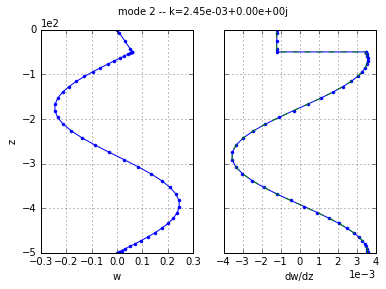

In [48]:
imod = 2

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(ww[:,imod], zz, '.-')
axs[0].set_xlabel('w')
axs[0].set_ylabel('z')
axs[1].plot(dw[:,imod], zz, '.-')
axs[1].plot(np.dot(Dz,ww[:,imod]), zz, '--')
axs[1].set_xlabel('dw/dz')

for ax in axs:
    ax.grid(True)
    ax.ticklabel_format(style='sci',scilimits=(-2,2))
fig.suptitle('mode {0:01d} -- k={1:.2e}'.format(imod,np.sqrt(lam[imod])))

## Old Stuff

In [ ]:
def cheb(N, inter=None):
    N -= 1

    if N==0:
        return None
    xx = np.cos(np.pi*np.arange(N+1)/N)
    cc = np.r_[2, np.ones(N-1), 2]*(-1)**np.arange(N+1)
    X = np.tile(xx[:,None], (1, N+1))
    dX = X - X.T
    D = (cc[:,None]/cc[None,:])/(dX + np.diag(np.ones(N+1)))
    D = D - np.diag(D.sum(axis=1))

    if not inter is None:
        L = inter[1] - inter[0]
        D = -D*2/L
        xx = (xx[::-1] + 1) * L/2. + inter[0]
    return D, xx



def ML_solver(zin, Din, Nsqin, zml, Dml, Nsqml, gred):
    Nin = len(zin)
    Nml = len(zml)
    nmod = ((Nin+Nml)//4)
    Lin = np.r_[ np.c_[ np.zeros((Nin,Nin)),     -Din ] \
                , np.c_[ Din,              np.zeros((Nin,Nin)) ] ]
    Lml = np.r_[ np.c_[ np.zeros((Nml,Nml)),    -Dml ] \
               , np.c_[ Dml,              np.zeros((Nml,Nml)) ] ]

    LL = np.zeros((2*Nz,2*Nz))
    LL[:2*Nin,:2*Nin] = Lin
    LL[2*Nin:,2*Nin:] = Lml

    AA = np.diag(np.r_[np.ones(Nin), Nsqin, np.ones(Nml), Nsqml])

    # B.C.
    # w = 0 at z=-Hb, 0
    LL[Nin,:] = np.r_[ np.zeros(Nin), 1, np.zeros(Nin-1+2*Nml) ]
    LL[-1,:] = np.r_[ np.zeros(2*Nz-1), 1 ]
    AA[Nin,Nin] = AA[-1,-1] = 0
    # continuity of w
    LL[2*Nin-1,:] = np.r_[ np.zeros(2*Nin-1), 1, np.zeros(Nml), -1, np.zeros(Nml-1) ]
    AA[2*Nin-1,2*Nin-1] = 0
    # jump in dw/dz
    LL[2*Nin+Nml,:] = np.r_[ np.zeros(Nin-1), 1, np.zeros(Nin), -1, np.zeros(2*Nml-1) ]
    AA[2*Nin+Nml,2*Nin+Nml] = -gred

    lam, vect = eig(LL, AA)
    lom = lam.copy()
    # clean that shit
    inds, = np.where( (np.isfinite(lam)) & (abs(lam.real)<1e3) & (abs(lam.imag)<1e-6) & (lam.real>1e-10) )
    lam, vect = lam[inds], vect[:,inds]
    inds = lam.real.argsort()[:2*nmod]
    vect = vect[:,inds]

    lam = lam[inds]
    ww = np.r_[vect[Nin:2*Nin,:], vect[-Nml:,:]]
    dw = np.r_[vect[:Nin,:], vect[2*Nin:2*Nin+Nml,:]]
    
    return lam, ww, dw

def fasa(kks, dml, Nsqin, gred):
    return 1./(Nsqin*kks**2*dml**2 + (1-kks**2*gred*dml)**2)

In [3]:
# WKBJ functions: not that these are actual w, dw/dz (i.e. does not match wo, do)

def w_ml(z, Nml=0, k=None, dml=None):
    """ z[-1] = 0 // normalized such that w_ml(-dml)=1  ; Nml constant only"""
    if dml is None:
        if isinstance(z, np.ndarray): 
            dml = z[0]
        else:
            dml = -1
    if np.isclose(Nml, 0):
        return z/dml
    elif Nml > 0:
        return np.sin(k*Nml*z)/np.sin(k*Nml*dml)
    elif Nml < 0:
        return np.sinh(k*Nml*z)/np.sinh(k*Nml*dml)
    
def dwdz_ml(z, Nml=0, k=None, dml=None):
    """ z[-1] = 0 // normalized such that w_ml(-dml)=0 ; 
        Nml constant only"""
    if dml is None:
        if isinstance(z, np.ndarray): 
            dml = z[0]
        else:
            dml = -1.
    if not isinstance(z, np.ndarray): z = np.array([z])
    if isinstance(k, np.ndarray) and k.ndim == 1:
        k = k[None,:]
        shapout = (len(z),len(k))
    else: shapout = z.shape
    if np.isclose(Nml, 0):
        return np.ones(shapout)/dml
    elif Nml > 0:
        return k * Nml * np.cos(k*Nml*z[:,none])/np.sin(k*Nml*dml)
    elif Nml < 0:
        return np.cosh(k*Nml*z[:,None])/np.sinh(k*Nml*dml)
    
def w_in(zin, Nsqin, k):
    if zin.shape != Nsqin.shape: zin = zin.reshape(Nsqin.shape) #raise ValueError("something wrong")
    mwkb = itg.cumtrapz(np.sqrt(Nsqin), zin, initial=0)
    if isinstance(k, np.ndarray) and k.ndim == 1:
        k = k[None,:]
    return np.sin(k*mwkb[:,None])/(Nsqin[0]*Nsqin[:,None])**(1./4)/k

def dwdz_in(zin, Nsqin, k):
    if zin.shape != Nsqin.shape: raise ValueError("something wrong")
    mwkb = itg.cumtrapz(np.sqrt(Nsqin), zin, initial=0)
    if isinstance(k, np.ndarray) and k.ndim == 1:
        k = k[None,:]
    return np.cos(k*mwkb[:,None])*(Nsqin[:,None]/Nsqin[0])**(1./4)

def tr_ek(k, Nml, Nsqin, gred):
    if not isinstance(k, np.ndarray): k = np.array([k])
    wml = w_in(zin, Nsqin, k[None,:])[-1,:]
    dwml = dwdz_ml(-dml, Nml, k[None,:], dml=-dml) * wml
    return (dwml - dwdz_in(zin, Nsqin, k[None,:])[-1,:])/k + gred*wml*k


In [46]:
def sym_sqrt(data):
    return np.sign(data)*np.sqrt(abs(data))

def get_ModAmpRat(path_strat, Nz, Hbt, dml, gred, zref, zpyc, Nsqml, coef_realstrat):
    """ Big Wrapper"""
    zin, Din, zml, Dml, zz, Dz = ML_solver_grid(Nz, Hbt, dml)
    Nsqin, Nsqml, bvf_int = get_strat(path_strat, zin, zml, dml, zpyc, Nsqml, coef_realstrat=1.)   
    izref = abs(zref-zin).argmin()
    Nin, Nml = len(zin), len(zml)

    # solve eigenproblem
    lom, wo, do = ML_solver(zin, Din, Nsqin, zml, Dml, Nsqml, gred)
    # normalize
    amp = np.sqrt(wo[:Nin,:]**2*np.sqrt(Nsqin)[:,None] \
              + (do[:Nin,:]**2/np.sqrt(Nsqin)[:,None])).mean(axis=0)
    wo /= do[:1,:]
    amp /= do[0,:]
    do /= do[:1,:]
    
    ratio = ((do[-Nml:,:])**2).mean(axis=0) / np.sqrt(Nsqin[izref]/Nsqin[0])
    return (lom, ratio)
                                                      
def get_WKBampRat(kks, dml, Hbt, zref, zpyc, Nsqml, gred, path_strat): # TODO
    """ amplitude ratio from WKBJ estimate
    kks: np.ndarray 1D,  is initial guess for every eigenvalues (typically use results from EVP)
    dml, Hbt: depth of ML, depth of fluid (positive) 
    zref, zpyc: rerference depth (negative) and pycnocline depth (negative)
    Nsqml, gred: BVF in mixed layer (e.g. 0.) and buoyancy gap at bottom of ML
    path_strat: where to read strat.
    """
    Nz = 120
    Nzml = min(round(dml/Hbt*Nz), 10)
    Nzin = Nz - Nzml
    zml = np.linspace(-dml, 0, Nzml)
    zin = np.linspace(-Hbt, -dml, Nzin)
    Nsqin, Nsqml, _ = get_strat(path_strat, zin, zml, dml, zpyc, Nsqml, coef_realstrat=1.)
    Nsqref = itp.interp1d(zin, Nsqin)(zref)
    kzos = np.zeros(lom.shape)
    ff = lambda k:tr_ek(k, sym_sqrt(Nsqml), zin, Nsqin, gred).squeeze()
    for ii,ll in enumerate(kks.real):
        kzos[ii] = opt.fsolve(ff, ll)[0]
    wkb_ratref = ((dwdz_ml(zml, sym_sqrt(Nsqml.mean()), kzos) \
           * w_in(zin, Nsqin, kzos)[-1,:])**2).mean(axis=0) / np.sqrt(Nsqref/Nsqin[0])
    return wkb_ratref